In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import operator
from typing import Annotated, List, Literal, Optional

from pydantic import BaseModel, Field


class SolutionEvaluation(BaseModel):
    solution_idx: int = Field(description="Index of the solution.", ge=0)
    criterion: str = Field(description="Criterion, the solution is evaluated by.")
    score: int = Field(description="Score of the solution.", ge=0, le=10)


class SolutionsEvaluations(BaseModel):
    solutions_evaluations: List[SolutionEvaluation] = Field(
        description="List of evaluations of all solutions."
    )


class OverallState(BaseModel):
    year: int = Field(description="Year of chosen Advent of Code.", ge=2015, le=2024)
    day: int = Field(description="Day of chosen Advent of Code (1-25).", ge=1, le=25)
    programming_language: Literal["Python", "JavaScript", "TypeScript"] = Field(
        description="The programming language, the puzzle should be solved in."
    )

    puzzle_url: Optional[str] = Field(
        default=None, description="The URL to the chosen Advent of Code puzzle."
    )
    puzzle_description: Optional[str] = Field(
        default=None, description="The puzzle description."
    )

    solutions: Annotated[List[str], operator.add] = Field(
        default=[], description="A list of all codes that solve the given puzzle."
    )
    evaluations: Annotated[List[SolutionsEvaluations], operator.add] = Field(
        default=[], description="A list of all evaluations of all solutions."
    )
    best_solution_idx: Optional[int] = Field(
        default=None, description="The index of the best solution code."
    )
    best_solution: Optional[str] = Field(
        default=None, description="The best code to solve the given puzzle."
    )

In [3]:
def get_advent_of_code_url(year: int, day: int) -> str:
    return f"https://adventofcode.com/{year}/day/{day}"


def get_puzzle_url(state: OverallState) -> OverallState:
    return {"puzzle_url": get_advent_of_code_url(state.year, state.day)}

In [4]:
from langchain_community.document_loaders import WebBaseLoader


def get_visible_content_of_website(url: str) -> str:
    loader = WebBaseLoader(
        web_path=url, bs_get_text_kwargs={"separator": " ", "strip": True}
    )
    document = loader.load()[0]
    return document.page_content


def get_puzzle_description(state: OverallState) -> OverallState:
    return {"puzzle_description": get_visible_content_of_website(state.puzzle_url)}

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
from typing import List, Tuple

from langchain_core.language_models import BaseChatModel
from langchain_google_genai import ChatGoogleGenerativeAI


def get_models() -> List[Tuple[str, BaseChatModel]]:
    return [
        ("gemini_1_5_pro", ChatGoogleGenerativeAI(model="gemini-1.5-pro")),
        ("gemini_1_5_flash", ChatGoogleGenerativeAI(model="gemini-1.5-flash")),
        ("gemini_1_5_flash_8b", ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b")),
    ]

In [6]:
from functools import partial
from typing import Callable

from langchain_core.language_models import BaseChatModel
from langchain_core.messages import HumanMessage, SystemMessage


def solve_puzzle(state: OverallState, model: BaseChatModel) -> OverallState:
    messages = [
        SystemMessage(
            content=(
                "You are a helpful assistant tasked with solving programming puzzles. "
                "You should only return the actual code. "
                "The code should be directly runnable (i.e. no surrounding comments like '```')."
                "All descriptions must be part of comments within the code itself."
            )
        ),
        HumanMessage(
            content=(
                f"Solve the following puzzle in the '{state.programming_language}' programming language:\n"
                "```\n"
                f"{state.puzzle_description}"
                "```"
            )
        ),
    ]

    solution = model.invoke(messages).content
    return {"solutions": [solution]}


def get_solve_puzzle_node(
    model: BaseChatModel,
) -> Callable[[OverallState], OverallState]:
    return partial(solve_puzzle, model=model)


def get_solve_puzzle_node_name(name: str) -> str:
    return f"solve_puzzle_using_{name}"

In [7]:
def gather_solutions(state: OverallState) -> OverallState:
    return {}

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI


def get_criterions() -> List[str]:
    return ["efficiency", "readability"]


def evaluate_solutions(state: OverallState, criterion: str) -> OverallState:
    solutions_text = ""
    for idx, solution_text in enumerate(state.solutions):
        solutions_text += f"Solution {idx}:\n" "'''\n" f"{solution_text}" "'''\n" "\n"

    messages = [
        SystemMessage(
            content=(
                "You are a helpful assistant tasked with evaluating solutions to programming puzzles. "
                "You will get a list of solutions (code). "
                "You evaluate the solutions according to a given criterion. "
                "The actual evaluation is a number between 0 (worst) and 10 (best)."
            )
        ),
        HumanMessage(
            content=(
                "Given the following programming puzzle description: \n"
                "```\n"
                f"{state.puzzle_description}"
                "```\n"
                "\n"
                f"Also given the following solutions in the {state.programming_language} programming language:\n"
                "```\n"
                f"{solutions_text}"
                "```\n"
                "\n"
                f"Evaluate the solutions according to the criterion '{criterion}'."
            )
        ),
    ]

    model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
    model_with_structured_output = model.with_structured_output(SolutionsEvaluations)
    solution_evaluations = model_with_structured_output.invoke(messages)
    return {"evaluations": [solution_evaluations]}


def get_evaluate_solutions_node(
    criterion: str,
) -> Callable[[OverallState], OverallState]:
    return partial(evaluate_solutions, criterion=criterion)


def get_evaluate_solutions_node_name(criterion: str) -> str:
    return f"evaluate_solutions_regarding_{criterion}"

In [9]:
from collections import defaultdict


def aggregate_evalutions(state: OverallState) -> OverallState:
    overall_scores = defaultdict(int)
    for solutions_evaluations in state.evaluations:
        for evaluation in solutions_evaluations.solutions_evaluations:
            overall_scores[evaluation.solution_idx] += evaluation.score
    sorted_overall_scores = sorted(
        [
            (overall_score, solution_idx)
            for solution_idx, overall_score in overall_scores.items()
        ],
        key=lambda t: t[0],
        reverse=True,
    )
    best_solution_idx = sorted_overall_scores[0][1]
    return {
        "best_solution_idx": best_solution_idx,
        "best_solution": state.solutions[best_solution_idx],
    }

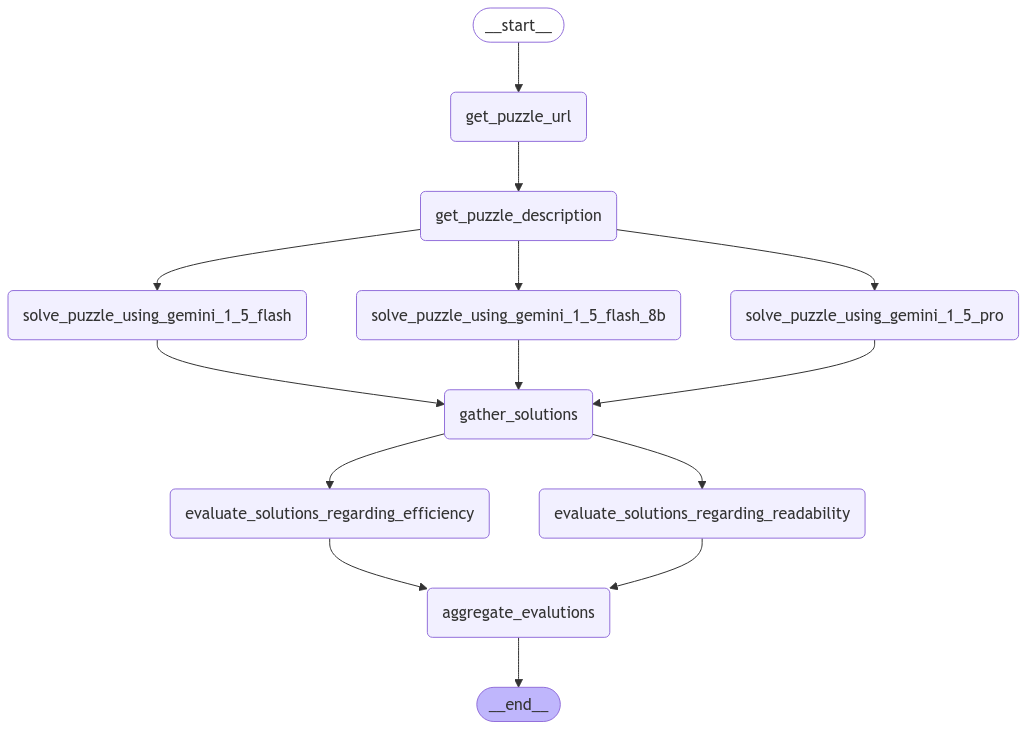

In [10]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.graph.graph import CompiledGraph


def create_graph() -> CompiledGraph:
    workflow = StateGraph(OverallState)

    # Nodes
    workflow.add_node("get_puzzle_url", get_puzzle_url)
    workflow.add_node("get_puzzle_description", get_puzzle_description)
    for name, model in get_models():
        workflow.add_node(
            get_solve_puzzle_node_name(name), get_solve_puzzle_node(model)
        )
    workflow.add_node("gather_solutions", gather_solutions)
    for criterion in get_criterions():
        workflow.add_node(
            get_evaluate_solutions_node_name(criterion),
            get_evaluate_solutions_node(criterion),
        )
    workflow.add_node("aggregate_evalutions", aggregate_evalutions)

    # Edges
    workflow.add_edge(START, "get_puzzle_url")
    workflow.add_edge("get_puzzle_url", "get_puzzle_description")
    for name, model in get_models():
        node_name = get_solve_puzzle_node_name(name)
        workflow.add_edge("get_puzzle_description", node_name)
        workflow.add_edge(node_name, "gather_solutions")
    for criterion in get_criterions():
        node_name = get_evaluate_solutions_node_name(criterion)
        workflow.add_edge("gather_solutions", node_name)
        workflow.add_edge(node_name, "aggregate_evalutions")
    workflow.add_edge("aggregate_evalutions", END)

    graph = workflow.compile()
    return graph


graph = create_graph()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"year": 2024, "day": 3, "programming_language": "Python"})

{'year': 2024,
 'day': 3,
 'programming_language': 'Python',
 'puzzle_url': 'https://adventofcode.com/2024/day/3',
 'puzzle_description': 'Day 3 - Advent of Code 2024 Advent of Code [About] [Events] [Shop] [Log In] <y> 2024 </y> [Calendar] [AoC++] [Sponsors] [Leaderboard] [Stats] Our sponsors help make Advent of Code possible: Honeycomb.io - Honeycomb offers unlimited dimensionality when storing, querying, and correlating data, helping developers find problems quickly. --- Day 3: Mull It Over --- "Our computers are having issues, so I have no idea if we have any Chief Historians in stock ! You\'re welcome to check the warehouse, though," says the mildly flustered shopkeeper at the North Pole Toboggan Rental Shop . The Historians head out to take a look. The shopkeeper turns to you. "Any chance you can see why our computers are having issues again?" The computer appears to be trying to run a program, but its memory (your puzzle input) is corrupted . All of the instructions have been jum